#Notebook Walkthrough: Emotion Detection with Data Augmentation

# Emotion Detection with Data Augmentation

## Introduction
Emotion detection is a crucial task in natural language processing (NLP), enabling machines to understand and categorize human emotions expressed in text. It has applications in sentiment analysis, mental health monitoring, and customer feedback analysis.

In this notebook, we will build an emotion detection model using the **GoEmotions** dataset and a custom dataset formatted as `{sentence;label}`.

Key aspects of this project include:
- Preprocessing and cleaning the datasets.
- Augmenting the data to balance class distributions.
- Training and evaluating models for each dataset.
- Comparing results across datasets and providing insights into model performance.

### Objectives
1. Preprocess datasets and handle unique characteristics of each.
2. Use data augmentation to address class imbalance.
3. Train separate models for each dataset and evaluate their performance.
4. Demonstrate inference with real-world examples.

### First, we import all necessary librairies

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, ClassLabel
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch

and set the device for training

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


 The decision to map and reduce the emotions from 28 to 6 categories was driven by the need to simplify the classification task while ensuring the model remains practical and generalizable. Many of the original 27 emotions in the dataset overlap in meaning or represent nuanced variations that are challenging for machine learning models to distinguish reliably, especially with limited data. By clustering similar emotions into broader categories—such as joy, sadness, anger, love, fear, and surprise—we improve the model's ability to learn robust features, enhance interpretability, and make it more applicable for real-world use cases, where broader emotional categories are often sufficient for actionable insights

Define emotion mappings for Dataset 1 (GoEmotions)


In [4]:
emotion_mapping_1 = {
    0: 'joy', 1: 'joy', 2: 'anger', 3: 'anger', 4: 'love', 5: 'love',
    6: 'fear', 7: 'joy', 8: 'love', 9: 'sadness', 10: 'anger', 11: 'anger',
    12: 'sadness', 13: 'joy', 14: 'fear', 15: 'joy', 16: 'sadness',
    17: 'joy', 18: 'love', 19: 'fear', 20: 'joy', 21: 'joy',
    22: 'surprise', 23: 'joy', 24: 'sadness', 25: 'sadness', 26: 'surprise'
}

Define Class Labels for Dataset 2

In [5]:
class_labels = ClassLabel(names=["joy", "anger", "love", "sadness", "fear", "surprise"])

Here we define the preprocessing functions

In [6]:
def preprocess_dataset_1(file_path, emotion_mapping):
    """Preprocess GoEmotions Dataset"""
    print(f"Loading Dataset 1 from {file_path}")
    df = pd.read_csv(file_path, sep="\t", header=None, names=["text", "emotion_id", "id"])

    # Handle multi-label rows by taking the first valid emotion_id
    df["emotion_id"] = df["emotion_id"].apply(
        lambda x: int(str(x).split(",")[0]) if pd.notnull(x) else None
    )

    # Map emotion_id to labels
    df["label"] = df["emotion_id"].map(emotion_mapping)

    # Drop rows with missing or invalid labels
    df = df.dropna(subset=["label"])

    # Keep only relevant columns
    df = df[["text", "label"]]
    print(f"Processed Dataset 1 with {len(df)} rows")
    return df

def preprocess_dataset_2(file_path):
    """Preprocess Custom Dataset"""
    print(f"Loading Dataset 2 from {file_path}")
    df = pd.read_csv(file_path, sep=";", header=None, names=["text", "label"])
    print(f"Processed Dataset 2 with {len(df)} rows")
    return df

Augmentation Function

In [7]:
def augment_minority_classes(df, majority_class):
    """Augment minority classes to match the majority class size"""
    max_class_size = df["label"].value_counts()[majority_class]
    augmented_df = df.copy()

    for label in df["label"].unique():
        class_rows = df[df["label"] == label]
        num_to_duplicate = max_class_size - len(class_rows)
        if num_to_duplicate > 0:
            duplicated_rows = class_rows.sample(n=num_to_duplicate, replace=True, random_state=42)
            augmented_df = pd.concat([augmented_df, duplicated_rows], ignore_index=True)
            print(f"Augmented class '{label}' by duplicating {num_to_duplicate} rows.")

    return augmented_df

Visualization Functions

In [8]:
def plot_class_distribution(df, title):
    """Plot the class distribution"""
    df["label"].value_counts().plot(kind="bar", color="skyblue")
    plt.title(f"Class Distribution: {title}")
    plt.xlabel("Labels")
    plt.ylabel("Frequency")
    plt.show()

File Paths

In [9]:
# File paths
file_paths_1 = {
    "train": "/content/sample_data/goemotionstrain.tsv",
    "val": "/content/sample_data/goemotionsval.tsv",
    "test": "/content/sample_data/goemotionstest.tsv",
}
file_paths_2 = {
    "train": "/content/sample_data/train.txt",
    "val": "/content/sample_data/val.txt",
    "test": "/content/sample_data/test.txt",
}

Tokenization

In [10]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenization Function

In [11]:
# Step 1: Clean the Dataset
def clean_dataset(dataset):
    dataset = dataset[dataset['text'].apply(lambda x: isinstance(x, str))]
    dataset.reset_index(drop=True, inplace=True)
    return dataset

# Step 2: Encode Labels
def encode_labels(dataset, label_mapping):
    dataset['label'] = dataset['label'].map(label_mapping)
    return dataset

# Step 3: Tokenize and Convert to Hugging Face Dataset
def tokenize_and_convert_to_dataset(dataset, tokenizer):
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding=True, truncation=True)

    hf_dataset = Dataset.from_pandas(dataset)
    tokenized_dataset = hf_dataset.map(tokenize_function, batched=True)
    return tokenized_dataset

# Label Mappings
label_mapping_1 = {"joy": 0, "anger": 1, "love": 2, "sadness": 3, "fear": 4, "surprise": 5}
label_mapping_2 = {"joy": 0, "anger": 1, "love": 2, "sadness": 3, "fear": 4, "surprise": 5}

##Data Part

## Dataset 1: Preprocessing (GoEmotions)

The **GoEmotions** dataset is a multi-label dataset where each text sample is annotated with one or more emotion IDs. To use this dataset for single-label classification, we:
1. **Mapped emotion IDs to meaningful labels** using a predefined mapping.
2. **Handled multi-label samples** by selecting the first valid emotion ID.
3. **Dropped invalid rows** with missing or unmapped emotion IDs.



Processing Dataset 1 (GoEmotions)...
Loading Dataset 1 from /content/sample_data/goemotionstrain.tsv
Processed Dataset 1 with 30587 rows
Loading Dataset 1 from /content/sample_data/goemotionsval.tsv
Processed Dataset 1 with 3834 rows
Loading Dataset 1 from /content/sample_data/goemotionstest.tsv
Processed Dataset 1 with 3821 rows


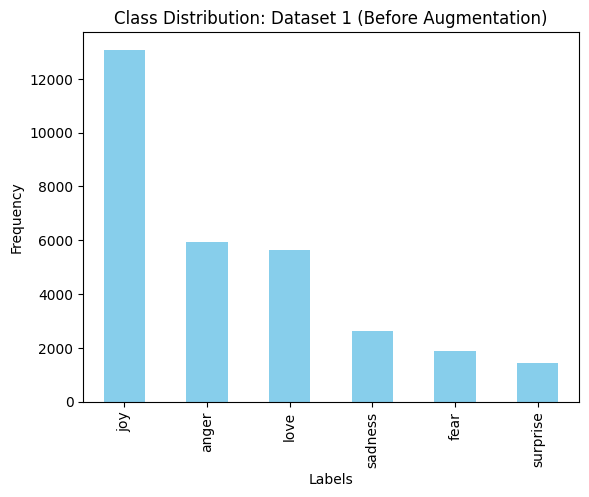

In [12]:
# Preprocess datasets
print("\nProcessing Dataset 1 (GoEmotions)...")
train_1 = preprocess_dataset_1(file_paths_1["train"], emotion_mapping_1)
val_1 = preprocess_dataset_1(file_paths_1["val"], emotion_mapping_1)
test_1 = preprocess_dataset_1(file_paths_1["test"], emotion_mapping_1)

plot_class_distribution(train_1, "Dataset 1 (Before Augmentation)")

## Dataset 1: Data Augmentation

The class distribution in the GoEmotions dataset is imbalanced, with some emotions occurring far less frequently than others. To address this:
- We identify the majority class (e.g., "joy") and duplicate samples from minority classes to match its size.
- This approach helps the model learn more robust features for all classes.

### Key Benefits:
- Prevents overfitting to majority classes.
- Encourages the model to generalize better across all emotions.


Augmented class 'anger' by duplicating 7166 rows.
Augmented class 'fear' by duplicating 11199 rows.
Augmented class 'surprise' by duplicating 11633 rows.
Augmented class 'love' by duplicating 7444 rows.
Augmented class 'sadness' by duplicating 10463 rows.

Class Distribution After Augmentation (Dataset 1):


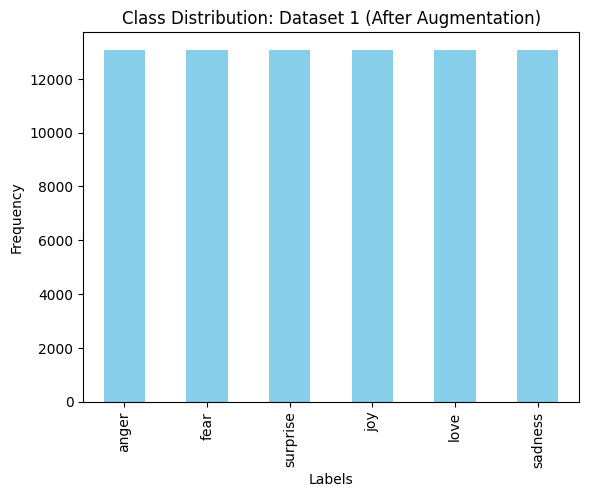

In [13]:
# Augment Dataset 1
train_1_augmented = augment_minority_classes(train_1, majority_class="joy")

# Display class distribution after augmentation
print("\nClass Distribution After Augmentation (Dataset 1):")
plot_class_distribution(train_1_augmented, "Dataset 1 (After Augmentation)")


## Dataset 2: Preprocessing (Custom Dataset)

The custom dataset has a simpler structure: each sample is a sentence paired with a single label in `{sentence;label}` format. For this dataset:
1. We split the text and labels based on the `;` delimiter.
2. We ensured the text column is clean and free of invalid entries.

This straightforward format makes the preprocessing step less complex than GoEmotions.


Loading Dataset 2 from /content/sample_data/train.txt
Processed Dataset 2 with 16000 rows
Loading Dataset 2 from /content/sample_data/val.txt
Processed Dataset 2 with 2000 rows
Loading Dataset 2 from /content/sample_data/test.txt
Processed Dataset 2 with 2000 rows

Class Distribution Before Augmentation (Dataset 2):


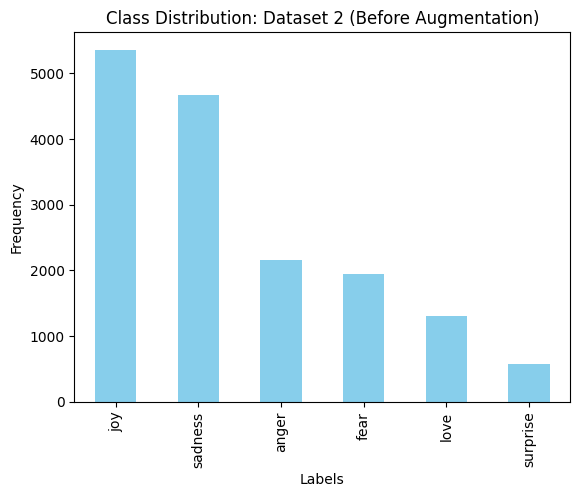

In [14]:
# Process Custom Dataset
train_2 = preprocess_dataset_2(file_paths_2["train"])
val_2 = preprocess_dataset_2(file_paths_2["val"])
test_2 = preprocess_dataset_2(file_paths_2["test"])

# Display class distribution before augmentation
print("\nClass Distribution Before Augmentation (Dataset 2):")
plot_class_distribution(train_2, "Dataset 2 (Before Augmentation)")


## Dataset 2: Data Augmentation

The custom dataset also has an imbalanced class distribution. We apply the same augmentation approach used for GoEmotions to balance the class sizes.


Augmented class 'sadness' by duplicating 696 rows.
Augmented class 'anger' by duplicating 3203 rows.
Augmented class 'love' by duplicating 4058 rows.
Augmented class 'surprise' by duplicating 4790 rows.
Augmented class 'fear' by duplicating 3425 rows.

Class Distribution After Augmentation (Dataset 2):


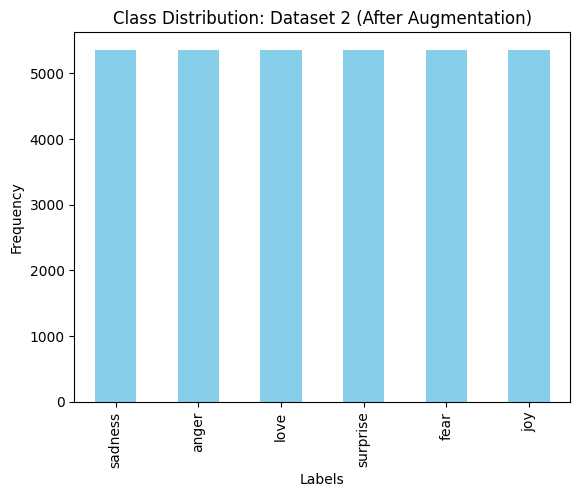

In [15]:
# Augment Dataset 2
train_2_augmented = augment_minority_classes(train_2, majority_class=train_2["label"].value_counts().idxmax())

# Display class distribution after augmentation
print("\nClass Distribution After Augmentation (Dataset 2):")
plot_class_distribution(train_2_augmented, "Dataset 2 (After Augmentation)")


## Tokenization

To prepare the text for training, we tokenize the sentences using the DistilBERT tokenizer. Tokenization ensures the text is converted into input IDs and attention masks suitable for the model.


In [16]:
# Dataset 1 Preprocessing
train_1_cleaned = clean_dataset(train_1_augmented)
val_1_cleaned = clean_dataset(val_1)
test_1_cleaned = clean_dataset(test_1)

train_1_cleaned = encode_labels(train_1_cleaned, label_mapping_1)
val_1_cleaned = encode_labels(val_1_cleaned, label_mapping_1)
test_1_cleaned = encode_labels(test_1_cleaned, label_mapping_1)

train_ds_1 = tokenize_and_convert_to_dataset(train_1_cleaned, tokenizer)
val_ds_1 = tokenize_and_convert_to_dataset(val_1_cleaned, tokenizer)
test_ds_1 = tokenize_and_convert_to_dataset(test_1_cleaned, tokenizer)

# Dataset 2 Preprocessing
train_2_cleaned = clean_dataset(train_2_augmented)
val_2_cleaned = clean_dataset(val_2)
test_2_cleaned = clean_dataset(test_2)

train_2_cleaned = encode_labels(train_2_cleaned, label_mapping_2)
val_2_cleaned = encode_labels(val_2_cleaned, label_mapping_2)
test_2_cleaned = encode_labels(test_2_cleaned, label_mapping_2)

train_ds_2 = tokenize_and_convert_to_dataset(train_2_cleaned, tokenizer)
val_ds_2 = tokenize_and_convert_to_dataset(val_2_cleaned, tokenizer)
test_ds_2 = tokenize_and_convert_to_dataset(test_2_cleaned, tokenizer)

Map:   0%|          | 0/78492 [00:00<?, ? examples/s]

Map:   0%|          | 0/3834 [00:00<?, ? examples/s]

Map:   0%|          | 0/3821 [00:00<?, ? examples/s]

Map:   0%|          | 0/32172 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [17]:
print(train_1_cleaned["label"].unique())  # Should output [0, 1, 2, 3, 4, 5]
print(train_2_cleaned["label"].unique())  # Should output [0, 1, 2, 3, 4, 5]


[1 4 5 0 2 3]
[3 1 2 5 4 0]


## Model Training

We train separate DistilBERT models for each dataset. Each model is fine-tuned using the augmented training data, with validation sets used for evaluation during training.


In [20]:
# Training function
def train_model(train_dataset, val_dataset, num_labels, model_name="distilbert-base-uncased"):
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)
    training_args = TrainingArguments(
    output_dir="./emotion_model",  # Specify the directory to save model checkpoints
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

    trainer = Trainer(
    model=model,
    args=training_args,  # output_dir is already part of training_args
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=lambda p: {
        "accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1)),
        "f1": f1_score(p.label_ids, np.argmax(p.predictions, axis=1), average="weighted"),
    },
)

    trainer.train()
    return trainer

In [21]:
# Train models
print("\nTraining model on Dataset 1...")
trainer_1 = train_model(train_ds_1, val_ds_1, num_labels=6)

print("\nTraining model on Dataset 2...")
trainer_2 = train_model(train_ds_2, val_ds_2, num_labels=len(train_2_augmented["label"].unique()))



Training model on Dataset 1...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-81d5fcada657>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.463900,0.988635,0.694053,0.705166
2,0.214800,1.189188,0.718571,0.721264
3,0.143700,1.446853,0.718571,0.719940



Training model on Dataset 2...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-81d5fcada657>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.163400,0.246431,0.932000,0.933762
2,0.095100,0.243689,0.938000,0.939047


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.163400,0.246431,0.932000,0.933762
2,0.095100,0.243689,0.938000,0.939047
3,0.053300,0.247008,0.936500,0.937093


## Evaluation

We evaluate the models on their respective test sets using accuracy and F1-score. These metrics provide insight into the model's ability to classify emotions correctly.


In [22]:
print("\nEvaluating model for Dataset 1...")
results_1 = trainer_1.evaluate(test_ds_1)
print("Evaluation Results for Dataset 1:", results_1)

print("\nEvaluating model for Dataset 2...")
results_2 = trainer_2.evaluate(test_ds_2)
print("Evaluation Results for Dataset 2:", results_2)


Evaluating model for Dataset 1...


Evaluation Results for Dataset 1: {'eval_loss': 1.5262902975082397, 'eval_accuracy': 0.712117246794033, 'eval_f1': 0.7125945033445851, 'eval_runtime': 5.4043, 'eval_samples_per_second': 707.035, 'eval_steps_per_second': 44.224, 'epoch': 3.0}

Evaluating model for Dataset 2...


Evaluation Results for Dataset 2: {'eval_loss': 0.2870708703994751, 'eval_accuracy': 0.926, 'eval_f1': 0.9271413989329942, 'eval_runtime': 3.8035, 'eval_samples_per_second': 525.826, 'eval_steps_per_second': 32.864, 'epoch': 3.0}


## Inference: Using the Trained Model to Predict Emotions

Inference refers to the process of utilizing a trained model to make predictions on new, unseen data. In the context of this project, inference involves inputting a text sentence (or multiple sentences) into the fine-tuned model, which then predicts the most likely emotion associated with the input along with a confidence score.

### Steps in Inference
1. **Tokenization**:
   The input sentence is tokenized, which means it is transformed into numerical representations such as input IDs and attention masks. These numerical tokens are what the model processes during inference.
   
2. **Model Prediction**:
   The tokenized input is fed into the fine-tuned model, which processes the input and outputs logits. Logits are raw, unnormalized scores corresponding to each emotion class.
   
3. **Logit Interpretation**:
   The logits are converted into probabilities using the softmax function. The emotion class with the highest probability is selected as the model's prediction. A confidence score (ranging from 0 to 1) is derived for the predicted emotion.

### Importance of Inference
Inference demonstrates the model's real-world usability. By predicting emotions for new sentences, we validate the model's ability to generalize and provide actionable insights based on textual input.

Below, we define an interactive function that allows the user to input sentences and get the predicted emotion and confidence score.


In [23]:

# Define the inference function
def predict_emotion(text, model, tokenizer, class_labels):
    """
    Predict emotion for a given text using the trained model.

    Args:
    - text (str): Input sentence to classify.
    - model: Trained model for emotion classification.
    - tokenizer: Tokenizer used during training.
    - class_labels: Class labels for decoding predictions.

    Returns:
    - emotion_label (str): Predicted emotion label.
    - confidence (float): Confidence score of the prediction.
    """
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)

    # Get predictions from the fine-tuned model
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    # Convert predicted label to emotion name using the label encoder
    emotion_label = class_labels.int2str(predicted_class)
    confidence = torch.softmax(logits, dim=1)[0, predicted_class].item()

    return emotion_label, confidence


# Interactive Inference
def interactive_inference(trainer, tokenizer, class_labels):
    """
    Allow the user to input text for emotion prediction.
    """
    model = trainer.model  # Get the model from the trainer
    while True:
        user_input = input("\nEnter a sentence to classify (or type 'exit' to quit): ")
        if user_input.lower() == "exit":
            print("Exiting inference...")
            break
        emotion, confidence = predict_emotion(user_input, model, tokenizer, class_labels)
        print(f"Predicted Emotion: {emotion} (Confidence: {confidence:.2f})")


# Perform inference for Dataset 1
print("\nInteractive Inference for Dataset 1")
interactive_inference(trainer_1, tokenizer, class_labels)

# Perform inference for Dataset 2
print("\nInteractive Inference for Dataset 2")
interactive_inference(trainer_2, tokenizer, class_labels)



Interactive Inference for Dataset 1

Enter a sentence to classify (or type 'exit' to quit): hi i love you
Predicted Emotion: love (Confidence: 1.00)

Enter a sentence to classify (or type 'exit' to quit): i am scared
Predicted Emotion: fear (Confidence: 1.00)

Enter a sentence to classify (or type 'exit' to quit): i woke up relaxed today
Predicted Emotion: surprise (Confidence: 0.62)

Enter a sentence to classify (or type 'exit' to quit): i am so grateful you exist
Predicted Emotion: joy (Confidence: 1.00)

Enter a sentence to classify (or type 'exit' to quit): this homework is amazing
Predicted Emotion: joy (Confidence: 1.00)

Enter a sentence to classify (or type 'exit' to quit): what the fuck do you think you are doing
Predicted Emotion: anger (Confidence: 1.00)

Enter a sentence to classify (or type 'exit' to quit): i feel like shit 
Predicted Emotion: anger (Confidence: 0.99)

Enter a sentence to classify (or type 'exit' to quit): i want to cry
Predicted Emotion: sadness (Confide

## Comparative Analysis with Traditional Machine Learning Models

In this section, we compare the performance of our fine-tuned DistilBERT model with traditional machine learning algorithms such as Logistic Regression, Support Vector Machines (SVM), and Random Forest.

This comparison allows us to:

1. Understand the advantages and limitations of deep learning models like DistilBERT compared to traditional algorithms.
2. Assess how simpler models perform on the same datasets.
3. Highlight the importance of leveraging pre-trained transformers for text classification tasks.

The metrics for comparison include:

- Accuracy: The percentage of correctly classified instances.
- F1-Score: The weighted average of precision and recall, balancing false positives and false negatives.
- Training Time: The time taken to train each model.

We plot these metrics in a bar chart to visualize the comparative performance across models.

Training Logistic Regression on Dataset 1 (GoEmotions)...
Logistic Regression: Accuracy=0.61, F1-Score=0.62, Training Time=24.28s
Training Random Forest on Dataset 1 (GoEmotions)...
Random Forest: Accuracy=0.62, F1-Score=0.61, Training Time=145.13s
Training Gradient Boosting on Dataset 1 (GoEmotions)...
Gradient Boosting: Accuracy=0.57, F1-Score=0.59, Training Time=179.75s
Training Logistic Regression on Dataset 2 (Custom Dataset)...
Logistic Regression: Accuracy=0.89, F1-Score=0.89, Training Time=4.05s
Training Random Forest on Dataset 2 (Custom Dataset)...
Random Forest: Accuracy=0.88, F1-Score=0.88, Training Time=35.02s
Training Gradient Boosting on Dataset 2 (Custom Dataset)...
Gradient Boosting: Accuracy=0.86, F1-Score=0.86, Training Time=98.31s
Evaluating DistilBERT on Dataset 1 (GoEmotions)...


DistilBERT: Accuracy=0.72, F1-Score=0.72, Training Time=4.95s
Evaluating DistilBERT on Dataset 2 (Custom Dataset)...


DistilBERT: Accuracy=0.94, F1-Score=0.94, Training Time=4.05s


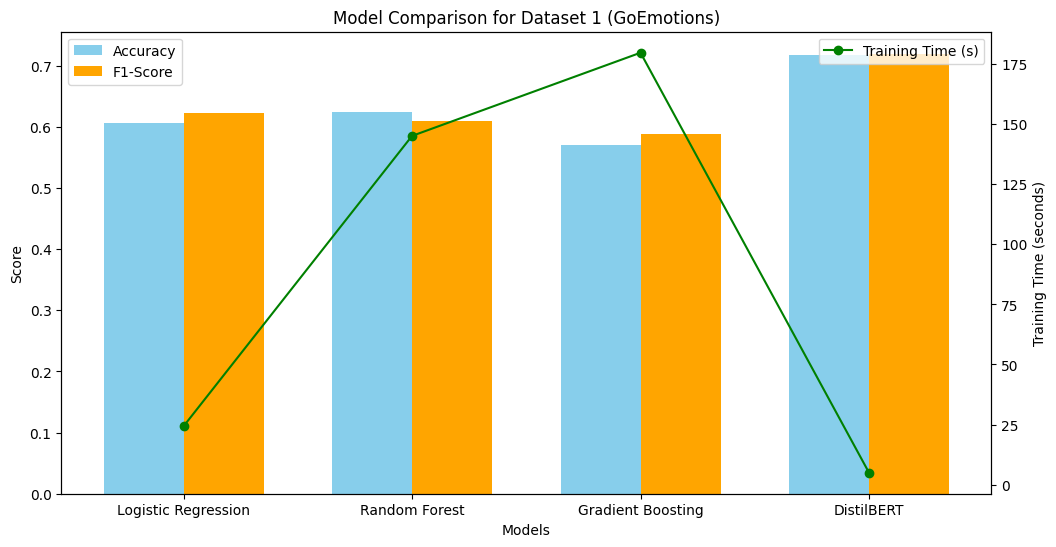

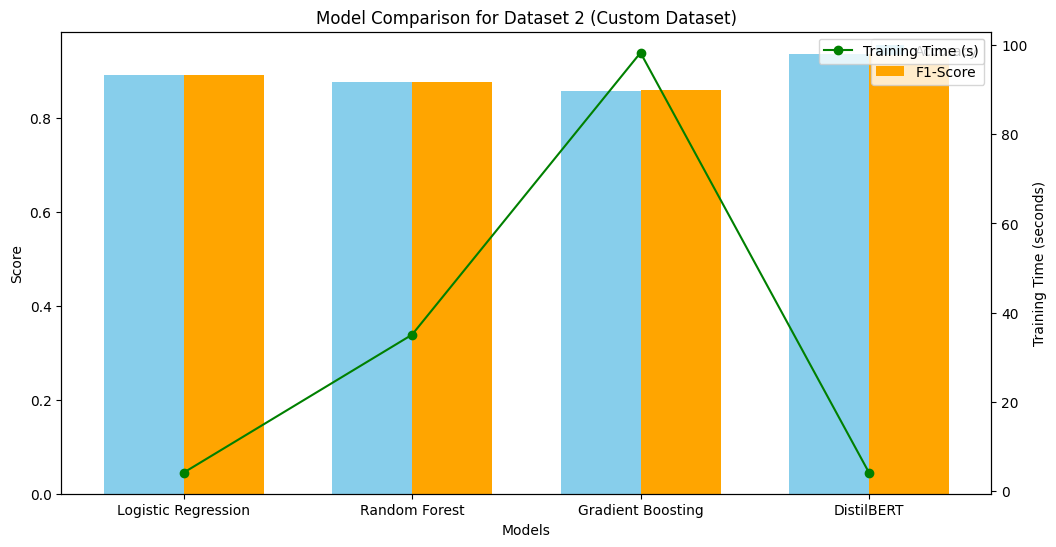

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score
import time
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Prepare the datasets for traditional models
def prepare_traditional_data(train_dataset, val_dataset):
    """
    Prepare the text data for traditional machine learning models using TF-IDF.
    Ensures consistent feature space between training and validation datasets.
    """
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train = vectorizer.fit_transform(train_dataset["text"])
    X_val = vectorizer.transform(val_dataset["text"])
    y_train = train_dataset["label"]
    y_val = val_dataset["label"]
    return X_train, y_train, X_val, y_val

# Dataset 1: GoEmotions
X_train_1, y_train_1, X_val_1, y_val_1 = prepare_traditional_data(train_1_cleaned, val_1_cleaned)

# Dataset 2: Custom Dataset
X_train_2, y_train_2, X_val_2, y_val_2 = prepare_traditional_data(train_2_cleaned, val_2_cleaned)

# Step 2: Define Traditional Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
}

# Step 3: Train and Evaluate Models
def evaluate_models(X_train, y_train, X_val, y_val, dataset_name):
    """
    Train and evaluate traditional machine learning models.
    """
    results = {}
    for model_name, model in models.items():
        print(f"Training {model_name} on {dataset_name}...")
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        y_pred = model.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average="weighted")
        results[model_name] = {"accuracy": acc, "f1_score": f1, "training_time": training_time}
        print(f"{model_name}: Accuracy={acc:.2f}, F1-Score={f1:.2f}, Training Time={training_time:.2f}s")
    return results

# Evaluate on Dataset 1
results_1 = evaluate_models(X_train_1, y_train_1, X_val_1, y_val_1, "Dataset 1 (GoEmotions)")

# Evaluate on Dataset 2
results_2 = evaluate_models(X_train_2, y_train_2, X_val_2, y_val_2, "Dataset 2 (Custom Dataset)")

# Combine results with DistilBERT performance
def add_distilbert_results(trainer, dataset_name, results_dict, val_dataset):
    """
    Add the DistilBERT model results to the comparison.
    """
    print(f"Evaluating DistilBERT on {dataset_name}...")
    start_time = time.time()
    distilbert_results = trainer.evaluate(val_dataset)
    training_time = time.time() - start_time
    accuracy = distilbert_results["eval_accuracy"]
    f1_score_value = distilbert_results["eval_f1"]
    results_dict["DistilBERT"] = {
        "accuracy": accuracy,
        "f1_score": f1_score_value,
        "training_time": training_time,
    }
    print(f"DistilBERT: Accuracy={accuracy:.2f}, F1-Score={f1_score_value:.2f}, Training Time={training_time:.2f}s")

# Add DistilBERT results to Dataset 1 and Dataset 2
add_distilbert_results(trainer_1, "Dataset 1 (GoEmotions)", results_1, val_ds_1)
add_distilbert_results(trainer_2, "Dataset 2 (Custom Dataset)", results_2, val_ds_2)

# Step 4: Plot Results
def plot_comparative_results(results, title):
    """
    Plot a bar chart comparing the performance of models.
    """
    models = list(results.keys())
    accuracies = [results[model]["accuracy"] for model in models]
    f1_scores = [results[model]["f1_score"] for model in models]
    training_times = [results[model]["training_time"] for model in models]

    # Plot Accuracy and F1-Score
    x = np.arange(len(models))
    width = 0.35
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.bar(x - width/2, accuracies, width, label="Accuracy", color="skyblue")
    ax1.bar(x + width/2, f1_scores, width, label="F1-Score", color="orange")
    ax1.set_xlabel("Models")
    ax1.set_ylabel("Score")
    ax1.set_title(title)
    ax1.set_xticks(x)
    ax1.set_xticklabels(models)
    ax1.legend()

    # Plot Training Times
    ax2 = ax1.twinx()
    ax2.plot(x, training_times, label="Training Time (s)", color="green", marker="o")
    ax2.set_ylabel("Training Time (seconds)")
    ax2.legend(loc="upper right")

    plt.show()

# Plot results for Dataset 1
plot_comparative_results(results_1, "Model Comparison for Dataset 1 (GoEmotions)")

# Plot results for Dataset 2
plot_comparative_results(results_2, "Model Comparison for Dataset 2 (Custom Dataset)")
